In [1]:
import numpy as np
#from uncertainties import ufloat, unumpy
#from uncertainties.umath import *
from astropy.io import fits
from astropy.table import Table
import scipy.stats as st

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

#from astropy.stats import LombScargle
#from scipy.ndimage.filters import gaussian_filter
from scipy import signal
# from importlib import reload as reload
import warnings
warnings.filterwarnings("ignore")

import astropy.io.fits as pyfits

from stingray.pulse.search import epoch_folding_search, z_n_search


from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile


In [2]:
plt.style.use('seaborn-notebook')
%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import seaborn as sns

sns.set(context='notebook',style='dark')
plt.style.use(['dark_background'])

In [4]:
image_file1 = 'pn_eventsclean_bary901.fits.gz'
# image_file1 = 'pn_eventsclean.fits'
# image_file2 =
imfits = pyfits.open(image_file1)

im = imfits[1].data

In [5]:
print(im.dtype)

(numpy.record, [('TIME', '>f8'), ('RAWX', '>i2'), ('RAWY', '>i2'), ('DETX', '>i2'), ('DETY', '>i2'), ('X', '>i4'), ('Y', '>i4'), ('PHA', '>i2'), ('PI', '>i2'), ('FLAG', '>i4'), ('PATTERN', 'u1'), ('PAT_ID', '>i2'), ('PAT_SEQ', 'u1'), ('CCDNR', 'u1'), ('TIME_RAW', '>f8')])


In [6]:
x = im['X']
y = im['Y']

<IPython.core.display.Javascript object>


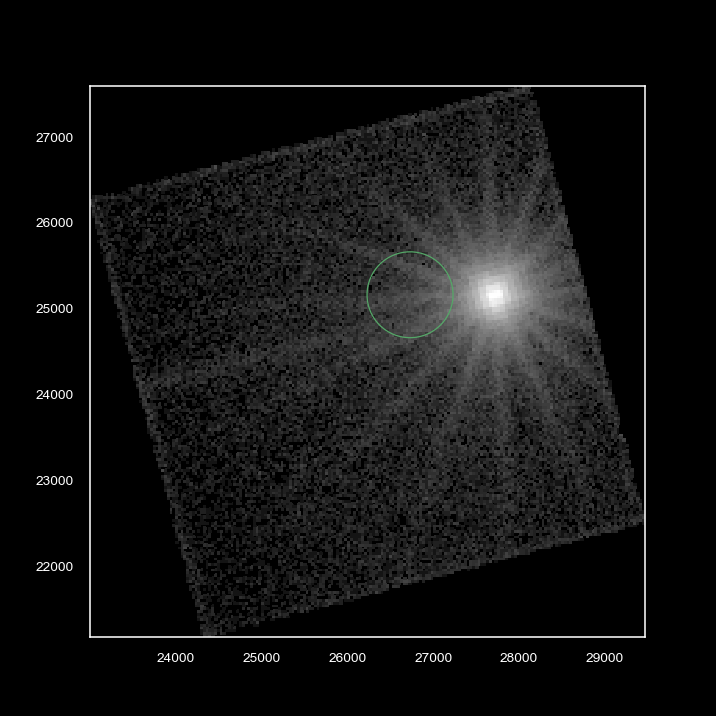

In [7]:
plt.close('all')
fig1=plt.figure(1,figsize=(8,8))
# plt.hist2d(x, y, bins=(200, 200), cmap=plt.cm.jet)
# plt.hist2d(x, y, bins=(200, 200), cmap=plt.cm.jet,norm=mpl.colors.LogNorm())
plt.hist2d(x, y, bins=(200, 200),cmap=mpl.cm.gray,norm=mpl.colors.LogNorm())
# circle=plt.Circle((27731,25164),500,color='g', fill=False)
circle=plt.Circle((26731,25164),500,color='g', fill=False)
plt.gca().add_patch(circle)
plt.show()


<IPython.core.display.Javascript object>


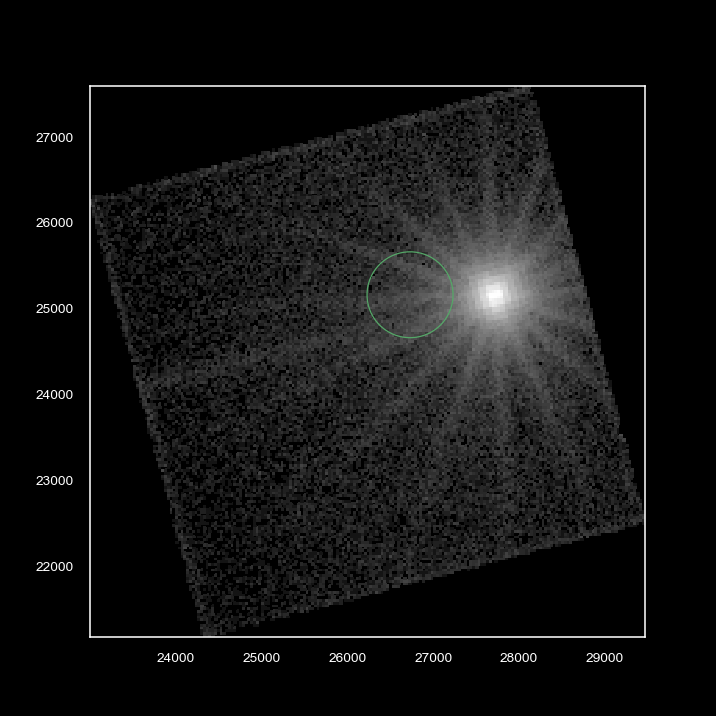

In [8]:
plt.close('all')
fig1=plt.figure(1,figsize=(8,8))
# plt.hist2d(x, y, bins=(200, 200), cmap=plt.cm.jet)
# plt.hist2d(x, y, bins=(200, 200), cmap=plt.cm.jet,norm=mpl.colors.LogNorm())
plt.hist2d(x, y, bins=(200, 200),cmap=mpl.cm.gray,norm=mpl.colors.LogNorm())
# circle=plt.Circle((27731,25164),500,color='g', fill=False)
circle=plt.Circle((26731,25164),500,color='g', fill=False)
plt.gca().add_patch(circle)
plt.show()

In [9]:
def in_circle(center_x, center_y, radius, x, y):
    square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
    return square_dist <= radius ** 2

In [10]:
dist = in_circle(27731,25164,500,x,y)

<IPython.core.display.Javascript object>


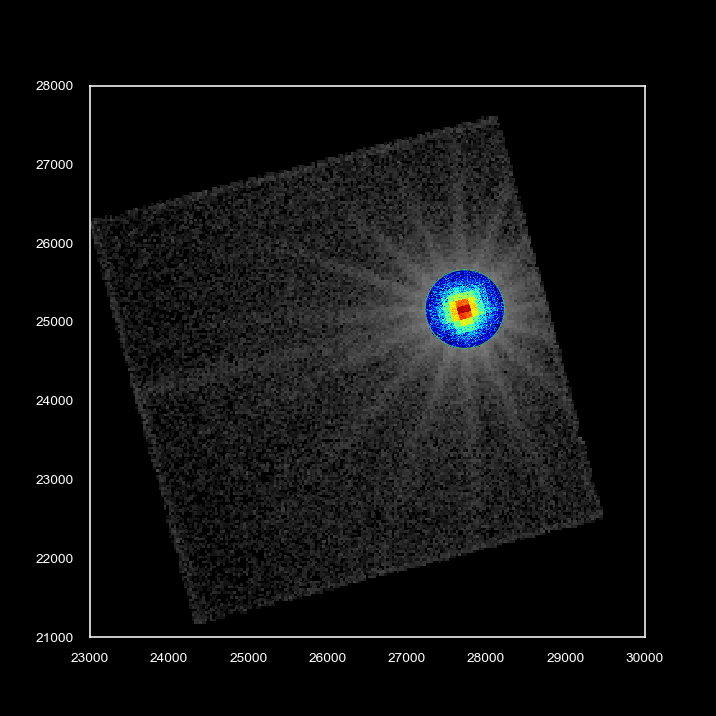

In [11]:
plt.close('all')
fig1=plt.figure(1,figsize=(8,8))
plt.hist2d(x, y, bins=(200, 200),cmap=mpl.cm.gray,norm=mpl.colors.LogNorm())
plt.hist2d(x[dist], y[dist], bins=(200, 200), cmap=plt.cm.jet,norm=mpl.colors.LogNorm())
circle=plt.Circle((27731,25164),500,color='g', fill=False)
plt.gca().add_patch(circle)
plt.xlim([23000,30000])
plt.ylim([21000,28000])
plt.show()

In [12]:
times0=im['time']
PI0=im['PI']

times = times0[dist]
PI = PI0[dist]

print(PI.min(), PI.max())

mask1 = (PI>200) & (PI<=10000)
mask2 = (PI>200) & (PI<=2000)
mask3 = (PI>2000) & (PI<=10000)

times1 = times[mask1]
times2 = times[mask2]
times3 = times[mask3]

151 31283


<IPython.core.display.Javascript object>


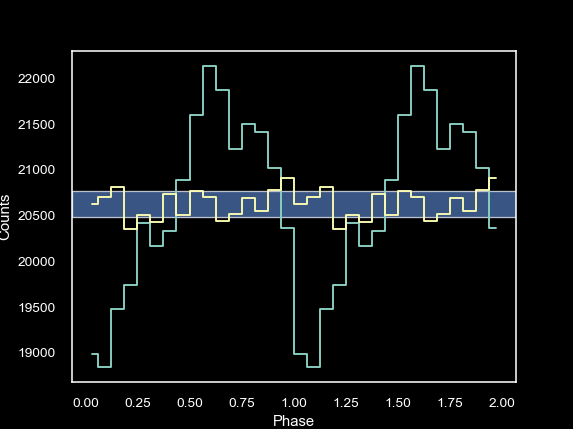

In [13]:
nbin = 16
period = 1/0.4215659378012899

ph, profile, profile_err = fold_events(times, 1/period, nbin=nbin)
_ = plot_profile(ph, profile)


# random time
ph, profile, profile_err = fold_events(times, 1/1.1, nbin=nbin)
_ = plot_profile(ph, profile)



<IPython.core.display.Javascript object>


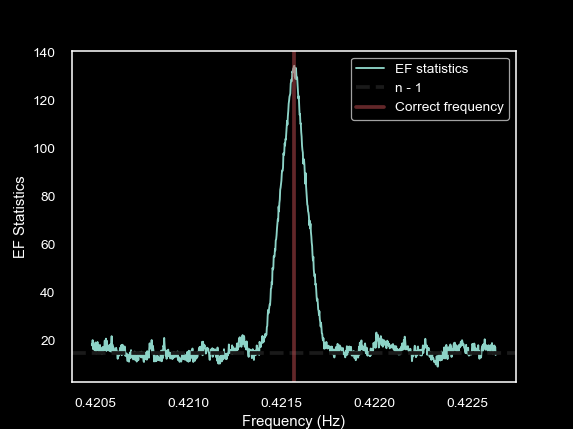

In [14]:
# We will search for pulsations over a range of frequencies around the known pulsation period.
obs_length = times.max()-times.min()
df_min = 1/obs_length
oversampling=15
df = df_min / oversampling
# frequencies = np.arange(1/period - 200 * df, 1/period + 200 * df, df)
frequencies = np.arange(1/period - 500 * df, 1/period + 500 * df, df)


freq, efstat = epoch_folding_search(times, frequencies, nbin=nbin)

# ---- PLOTTING --------
plt.figure()
plt.plot(freq, efstat, label='EF statistics')
plt.axhline(nbin - 1, ls='--', lw=3, color='k', label='n - 1')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
_ = plt.legend()


<IPython.core.display.Javascript object>


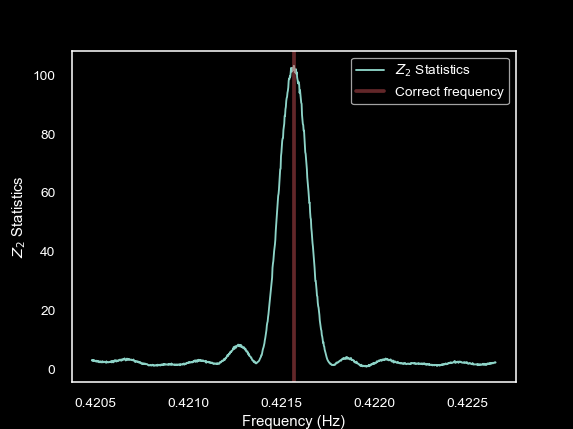

In [16]:
nharm = 1
freq, zstat = z_n_search(times, frequencies, nbin=nbin, nharm=nharm)

plt.figure()
plt.plot(freq, zstat, label='$Z_2$ Statistics')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('$Z_2$ Statistics')
_ = plt.legend()

In [17]:
from stingray.pulse.search import search_best_peaks
from stingray.stats import fold_detection_level, z2_n_detection_level

ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.001, ntrial=len(freq))
ef_detlev = fold_detection_level(nbin, epsilon=0.001, ntrial=len(freq))

cand_freqs_ef, cand_stat_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z, cand_stat_z = search_best_peaks(freq, zstat, z_detlev)

<IPython.core.display.Javascript object>


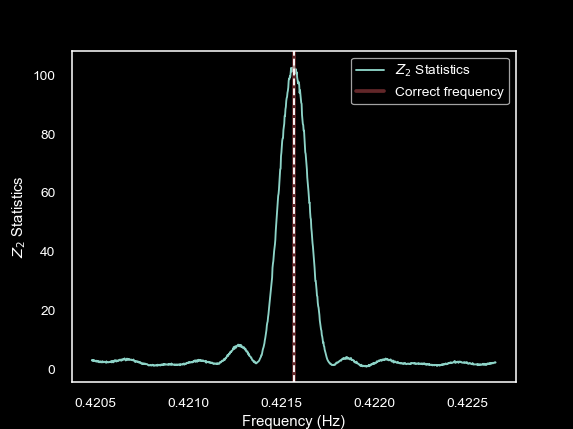

In [18]:
plt.figure()
plt.plot(freq, zstat, label='$Z_2$ Statistics')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('$Z_2$ Statistics')
_ = plt.legend()

for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

In [19]:
from stingray.pulse.modeling import fit_gaussian

fg=fit_gaussian(freq, efstat-(nbin-1),amplitude=max(efstat-(nbin-1)), 
                mean=cand_freqs_ef[0], stddev=1/(np.pi*obs_length))
fg
# fg.mean.value

<Gaussian1D(amplitude=113.43782855, mean=0.42156427, stddev=0.00006935)>

<IPython.core.display.Javascript object>


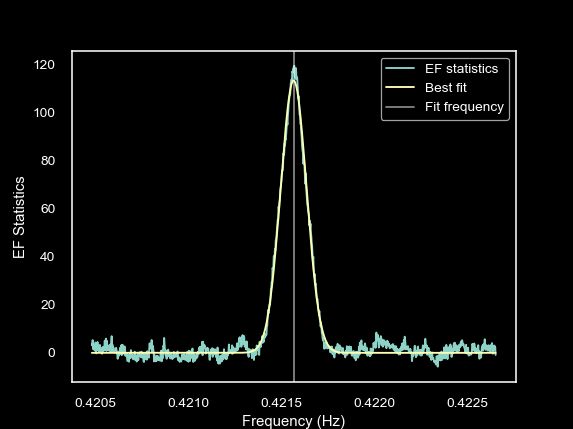

In [20]:
# ---- PLOTTING --------
# plt.close('all')
# fig1=plt.figure(1,figsize=(8,8))
plt.figure()
plt.plot(freq, efstat-(nbin-1), label='EF statistics')
plt.plot(freq, fg(freq), label='Best fit')
# plt.axvline(1/period, alpha=0.5, color='r', label='Correct frequency')
plt.axvline(fg.mean.value, alpha=0.5, label='Fit frequency')

plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
plt.legend()

# plt.figure(figsize=(15, 5))
# plt.plot(freq, efstat-(nbin-1)-fg(freq))
# plt.xlabel('Frequency (Hz)')
# _ = plt.ylabel('Residuals')
# plt.show()


<IPython.core.display.Javascript object>


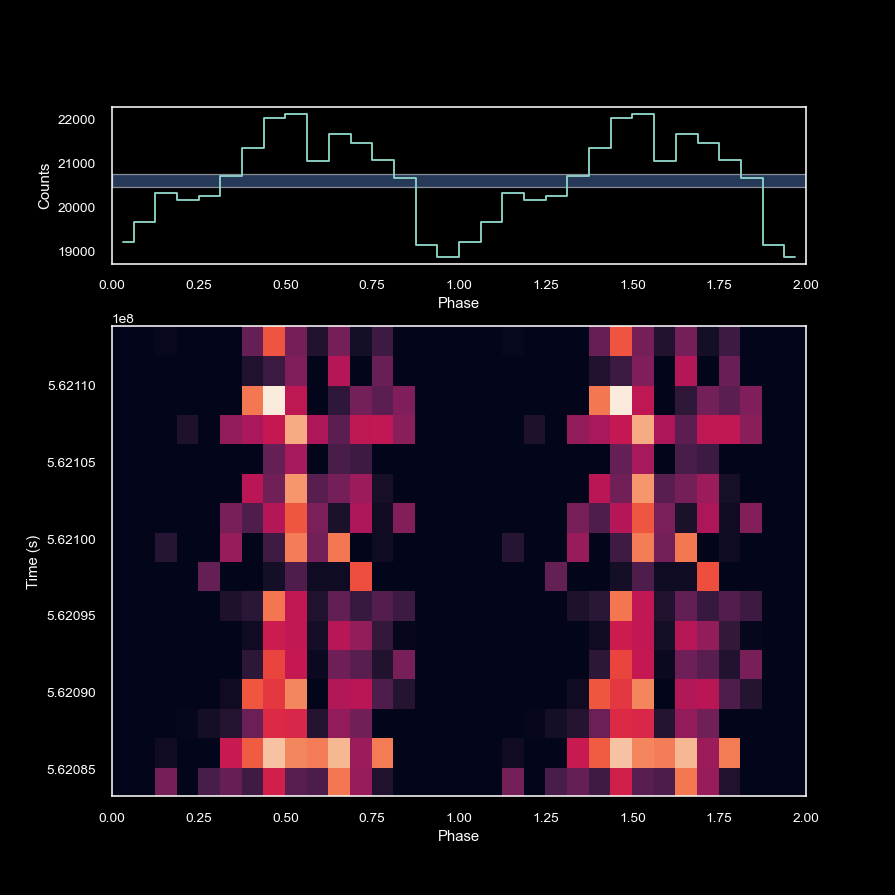

In [21]:
from stingray.pulse.search import phaseogram, plot_phaseogram, plot_profile
from matplotlib.gridspec import GridSpec

# # Calculate the phaseogram
# phaseogr, phases, tim, additional_info = \
#             phaseogram(times, cand_freqs_ef[0], return_plot=True, nph=16, nt=10)

phaseogr, phases, tim, additional_info = \
            phaseogram(times, 1/period, return_plot=True, nph=16, nt=16)
    
# ---- PLOTTING --------

# Plot on a grid
plt.figure(figsize=(10, 10))
gs = GridSpec(2, 1, height_ratios=(1, 3))
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

mean_phases = (phases[:-1] + phases[1:]) / 2
plot_profile(mean_phases, np.sum(phaseogr, axis=1), ax=ax0)
# Note that we can pass arguments to plt.pcolormesh, in this case vmin
_ = plot_phaseogram(phaseogr, phases, tim, ax=ax1, vmin=np.median(phaseogr))

